# Football transfer data 

### Group 103 

Samuel Amuzu, Nick Schaufelberger, Julian Purtschert

## Loading Libraries

We import the following libraries to improve our code’s efficiency and simplify data handling, visualization, and cleaning. These libraries help us manipulate data, create visualizations, extract information from websites, and perform mathematical operations more efficiently.

In [302]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup, Comment
import numpy as np
import re
from plotnine import *

## Loading Data

Our dataset, which is in addition to the scraping part, is the Football Transfer dataset from Kaggle. It contains detailed information on player transfers, fees, clubs, seasons, and positions for the biggest leagues in Europe from 2009 to 2021. The dataset consists of 23 columns and more than 70’000 entries. 

In [303]:
# This code loads the transfer data from a CSV file and displays the first five rows.
transfer_df = pd.read_csv("transfers.csv")
transfer_df.head(5)

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,...,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,...,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,...,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,...,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,...,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015


In [304]:
transfer_df.columns

Index(['league', 'season', 'window', 'team_id', 'team_name', 'team_country',
       'dir', 'player_id', 'player_name', 'player_age', 'player_nation',
       'player_nation2', 'player_pos', 'counter_team_id', 'counter_team_name',
       'counter_team_country', 'transfer_fee_amnt', 'market_val_amnt',
       'is_free', 'is_loan', 'is_loan_end', 'is_retired', 'transfer_id'],
      dtype='object')

The code loads successfully, displaying all columns with their respective headers. Next, we proceed to clean the data, check for gaps, verify data types, and identify any missing values

## Data Cleaning

## Checking for gaps / missing data

- Check for gaps / missing data 
- Check if columns show appropriate datatypes, change if needed 
- Check if values lie in the expected range 
- Identify outliers, treat them reasonably 
- Format your dataset suitable for your task (combine, merge, resample, …)  
- Enrich your dataset with at least one column of helpful additional information

First, we use the info() method to display some information about the dataset and the different data types that occur in it. We observe 70'006 entries and 23 columns, with 5 different data types present.

In [305]:
transfer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70006 entries, 0 to 70005
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   league                70006 non-null  object 
 1   season                70006 non-null  int64  
 2   window                70006 non-null  object 
 3   team_id               70006 non-null  int64  
 4   team_name             70006 non-null  object 
 5   team_country          70006 non-null  object 
 6   dir                   70006 non-null  object 
 7   player_id             70006 non-null  int64  
 8   player_name           70006 non-null  object 
 9   player_age            69990 non-null  float64
 10  player_nation         70001 non-null  object 
 11  player_nation2        23181 non-null  object 
 12  player_pos            70006 non-null  object 
 13  counter_team_id       70006 non-null  object 
 14  counter_team_name     70006 non-null  object 
 15  counter_team_countr

Next, we check for missing values. As seen in the code below, there are missing values in five columns. We need to take a closer look at the columns "player_age" and "player_nation".

The other three columns ("player_nation2", "transfer_fee_amnt", and "market_val_amnt") make sense to contain missing values. Many players do not have a second nationality, some are transferred for free or on loan which results in no transfer fee, and some may not yet have an assigned market value.

In the next step, we will examine the missing values in the "player_age" and "player_nation" columns in more detail.

In [306]:
transfer_df.isna().any()
transfer_df.isna().sum()

league                      0
season                      0
window                      0
team_id                     0
team_name                   0
team_country                0
dir                         0
player_id                   0
player_name                 0
player_age                 16
player_nation               5
player_nation2          46825
player_pos                  0
counter_team_id             0
counter_team_name           0
counter_team_country        0
transfer_fee_amnt       41743
market_val_amnt         19264
is_free                     0
is_loan                     0
is_loan_end                 0
is_retired                  0
transfer_id                 0
dtype: int64

In [307]:
missing_summary = transfer_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
print("Missing data per column:")
print(missing_summary)

Missing data per column:
player_age              16
player_nation            5
player_nation2       46825
transfer_fee_amnt    41743
market_val_amnt      19264
dtype: int64


In [308]:
# Rows where player_age or player_nation is missing
missing_players = transfer_df[transfer_df['player_age'].isna() | transfer_df['player_nation'].isna()]

# Display the relevant columns
missing_players[['player_name', 'player_age', 'player_nation']]

,player_name,player_age,player_nation
349,Stuart McDonald,NaN,NaN
1770,Stuart McDonald,NaN,NaN
4156,Reece Hayes,NaN,England
5596,Reece Hayes,NaN,England
7559,Dionatan Teixeira,NaN,Slovakia
9217,Emiliano Sala,NaN,Argentina
21706,Benjamin Owusu,NaN,Ghana
23189,Piermario Morosini,NaN,Italy
39591,Timon Fröhlich,19.0,NaN
39678,Niklas Feierabend,NaN,Germany


Since researching every player and filling in the missing values would be too cumbersome, and it’s also quite difficult to find data on some less well-known players, we decided not to fill in those values for the player_age and remove them entirely from our dataset instead

Also, since the column nation2 isn’t very interesting for us, so we decided to drop the column.

In [309]:
# Drop rows where player_age or player_nation is missing
transfer_df = transfer_df.dropna(subset=['player_age', 'player_nation'])
transfer_df = transfer_df.drop(columns=['player_nation2'])

For data cleaning and improved readability, we replaced NULL values in the transfer fee amount and market value amount columns with zeros.

In [310]:
transfer_df[['transfer_fee_amnt', 'market_val_amnt']] = transfer_df[['transfer_fee_amnt', 'market_val_amnt']].fillna(0)

We realized there were no duplicates, after checking for duplicates with the code below. However, we know from above that there are duplicate entries in some columns, which makes sense since some players get transferred a lot but not duplicates for the entire rows.

In [311]:
print(transfer_df.duplicated().any())
print(transfer_df.duplicated().sum())

False
0


## Changing datatypes

We performed further data exploration on the current data types for each column to make sure we are working with the correct data types for each column

In [312]:
transfer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 70005
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   league                69987 non-null  object 
 1   season                69987 non-null  int64  
 2   window                69987 non-null  object 
 3   team_id               69987 non-null  int64  
 4   team_name             69987 non-null  object 
 5   team_country          69987 non-null  object 
 6   dir                   69987 non-null  object 
 7   player_id             69987 non-null  int64  
 8   player_name           69987 non-null  object 
 9   player_age            69987 non-null  float64
 10  player_nation         69987 non-null  object 
 11  player_pos            69987 non-null  object 
 12  counter_team_id       69987 non-null  object 
 13  counter_team_name     69987 non-null  object 
 14  counter_team_country  69987 non-null  object 
 15  transfer_fee_amnt     69

Convert selected columns to categorical type, set player_age as integer, and ensure counter_team_id is stored as a numeric integer.

In [313]:
# Select all categorical columns
cat_cols = [
    'league', 'window', 'team_name', 'team_country', 'dir',
    'player_nation', 'player_pos',
    'counter_team_name', 'counter_team_country'
]

# Convert Categorical columns from objects to category
transfer_df[cat_cols] = transfer_df[cat_cols].astype('category')

# Convert Player age to Integer from a float
transfer_df['player_age'] = transfer_df['player_age'].astype('Int64')

# Convert counter_team_id from object to integer, coercing invalid values to NaN
transfer_df['counter_team_id'] = pd.to_numeric(transfer_df['counter_team_id'], errors='coerce').astype('Int64')

## Inspecting Unique Values

We decided to check for the unique values for all categorical variables to check for any inconsistencies. After we had a look at the unique values for the player position shows data inconsistency in this variable, However since those rows with these player positions account for less than 0.4% of our dataset, we decided to remove the rows without affecting the entire dataset. Also most of them were from the Italian league which we are not focusing on for our analysis and our analysis will be based on more specific positions which is why we decided to remove them.

In [314]:
# Number of unique values for each column
print(transfer_df.nunique())

# Checking for inconsistent categorical values
for col in [
    "league", "window", "team_name", "player_pos", "team_country", "dir", "player_name", "player_nation", "counter_team_id",
    "counter_team_name", "counter_team_country", "player_pos", "is_free", "is_loan", "is_loan_end", "is_retired"
]:
    print(col, transfer_df[col].unique())

league                      7
season                     13
window                      2
team_id                   239
team_name                 243
team_country                7
dir                         2
player_id               17571
player_name             17095
player_age                 33
player_nation             168
player_pos                 16
counter_team_id          3356
counter_team_name        3608
counter_team_country      125
transfer_fee_amnt         796
market_val_amnt           138
is_free                     2
is_loan                     2
is_loan_end                 2
is_retired                  2
transfer_id             58622
dtype: int64
league ['GB1', 'ES1', 'IT1', 'L1', 'FR1', 'PO1', 'NL1']
Categories (7, object): ['ES1', 'FR1', 'GB1', 'IT1', 'L1', 'NL1', 'PO1']
window ['s', 'w']
Categories (2, object): ['s', 'w']
team_name ['Manchester United', 'Liverpool FC', 'Chelsea FC', 'Arsenal FC', 'Everton FC', ..., 'SC Cambuur-Leeuwarden', 'Go Ahead Eagles', 'FC Do

In [315]:
# Players with "attack" position
attack = transfer_df[transfer_df["player_pos"] == "attack"]
attack.shape

# Players with "midfield" position
midfield = transfer_df[transfer_df["player_pos"] == "midfield"]
midfield.shape

# Players with "defence" position
defence = transfer_df[transfer_df["player_pos"] == "defence"]
defence.shape

# Identifying which leagues these positions account for
player_pos = transfer_df[transfer_df["player_pos"].isin(["attack", "midfield", "defence"])]
player_pos = (
    player_pos.groupby("league", observed = False)["player_pos"]
    .size()
    .reset_index()
)
print(player_pos)

  league  player_pos
0    ES1           6
1    FR1          17
2    GB1          24
3    IT1         114
4     L1           0
5    NL1          18
6    PO1          87


In [316]:
# Removing data with player position = midfield, attack and defence
transfer_df = transfer_df[~ transfer_df["player_pos"].isin(["attack", "midfield", "defence"])]
transfer_df["player_pos"].value_counts()

player_pos
CF          12327
CB          11520
CM           8183
GK           6287
DM           5737
LB           4948
AM           4696
RW           4686
RB           4523
LW           4385
SS           1078
LM            730
RM            621
attack          0
defence         0
midfield        0
Name: count, dtype: int64

In [317]:
# Drop levels that no longer exist in the player position column
transfer_df["player_pos"] = pd.Categorical(
    transfer_df["player_pos"].cat.remove_unused_categories()
)
transfer_df["player_pos"].value_counts()

player_pos
CF    12327
CB    11520
CM     8183
GK     6287
DM     5737
LB     4948
AM     4696
RW     4686
RB     4523
LW     4385
SS     1078
LM      730
RM      621
Name: count, dtype: int64

## Checking if values lie in the expected range (Outliers and Anomalies)

In this dataset, we only have a few numeric values that make sense to examine for outliers or anomalies. Therefore, in the next step, we print the basic statistics for the columns player age, transfer fee, and market value.

In [318]:
# Select Columns for statistical analysis
cols = ['player_age', 'transfer_fee_amnt', 'market_val_amnt']

# Summary statistics on selected columns
summary_stats = transfer_df[cols].agg(['count', 'mean', 'median', 'min', 'max']).T

summary_stats = summary_stats.round(2)

print(summary_stats)

                     count        mean    median   min          max
player_age         69721.0       24.18      23.0  12.0       1775.0
transfer_fee_amnt  69721.0  1524576.28       0.0   0.0  550000000.0
market_val_amnt    69721.0  2589315.56  325000.0   0.0  160000000.0


In the dataset, the Age column contains a clear outlier, a player listed as 1775 years old, which is obviously incorrect (unless we’re living in the Star Wars universe). The Market Value for Kylian Mbappé looks reasonable. However, we also need to take a closer look at the unusually high transfer fee for Simone Pesce, as that value doesn’t seem to make sense.

In [319]:
# Identify outlier of the player where player_age = 1775
outlier_info = transfer_df.loc[transfer_df['player_age'] == 1775,
                               ['player_name', 'team_name', 'season', 'player_age']]
print(outlier_info)

      player_name       team_name  season  player_age
55915      Califo  Gil Vicente FC    2014        1775


Since we didn’t find any information about this player’s age and he doesn’t seem to be relevant for our analysis or research question, we removed him from the dataset.

In [320]:
# Subset entire data except player with player_age = 1775
transfer_df = transfer_df[transfer_df['player_age'] != 1775]

After dropping the player from our dataset, we decided to explore the age distribution using a boxplot. It shows a reasonable distribution of the Age column in our dataset.

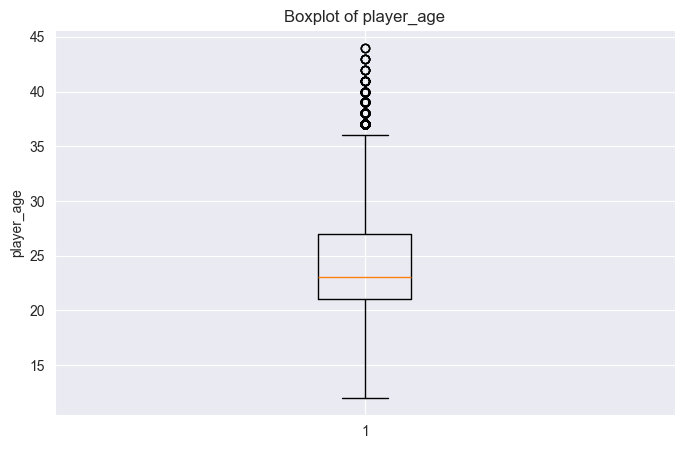

In [321]:
# Select player_age
col = 'player_age'

# Plot
plt.figure(figsize=(8, 5))
plt.boxplot(transfer_df[col], vert=True)
plt.title(f'Boxplot of {col}')
plt.ylabel(col)
plt.show()

Since the boxplot shows a lot of outliers, we looked at the top 20 players with the highest values. Based on our football knowledge, the four players listed make sense to have a high market value. Therefore, we won’t perform any further data cleaning on that column.

In [322]:
# Top 20 player names by market value
col = 'market_val_amnt'

# Sort values in descending order
top20_players = transfer_df.sort_values(by=col, ascending=False).head(20)

# Print
print("Top 20 players by market value:")
print(top20_players['player_name'].to_string(index=False))

Top 20 players by market value:
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
 Erling Haaland
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
Kevin De Bruyne


We realized while looking at the top 20 players by transfer fee amount that the data doesn’t make sense, as it might be an error in the dataset. We will be deleting all the players with a transfer fee of 500 million, as they all have the same value. After that, the next player is Neymar at 220 million. The one listed at 250 million also seems incorrect, so we’re removing that as well.

In [323]:
# Top 20 transfers
top_20_transfer = transfer_df.sort_values("transfer_fee_amnt", ascending=False).head(20)
print(top_20_transfer["player_name"].to_string(index = False))

         Simone Pesce
    Davide Bertoncini
Massimiliano Tagliani
    Leonardo Cisterni
    Angelo Bencivenga
      Luca Berardocco
   Alessandro Marotta
       Gianluca Curci
         Andrea Cocco
         Simone Pesce
      Andrea Paolucci
        Luca Tedeschi
         Danilo Russo
       Pablo Granoche
     Salvatore Burrai
       Luca Castiglia
    Guglielmo Vicario
       Riccardo Gatti
      Matteo Lombardo
        Mattia Marchi


In [324]:
# Subset for transfer fees less than or equal to 250 million
transfer_df = transfer_df[transfer_df['transfer_fee_amnt'] <= 222000000.0]

In [325]:
# Select transfer_fee_amnt column
col = 'transfer_fee_amnt'

# Select top 20 player with highest transfeer fee
top20_players_fee = transfer_df.sort_values(by=col, ascending=False).head(20)

# Print
print("Top 20 players by transfer fee amount:")
print(top20_players_fee['player_name'].to_string(index=False))

Top 20 players by transfer fee amount:
           Neymar
           Neymar
    Kylian Mbappé
    Kylian Mbappé
  Ousmane Dembélé
Philippe Coutinho
Philippe Coutinho
  Ousmane Dembélé
       João Félix
       João Félix
Antoine Griezmann
Antoine Griezmann
    Jack Grealish
    Jack Grealish
Cristiano Ronaldo
Cristiano Ronaldo
      Eden Hazard
    Romelu Lukaku
      Eden Hazard
    Romelu Lukaku


### Exploratory Data Analysis

1. We visualized the specific positions with the most transfers across the different leagues which led us to our first research question

In [326]:
transfer_df["player_pos"].unique()

['RB', 'CF', 'AM', 'CB', 'CM', ..., 'DM', 'SS', 'RW', 'LM', 'RM']
Length: 13
Categories (13, object): ['AM', 'CB', 'CF', 'CM', ..., 'RB', 'RM', 'RW', 'SS']

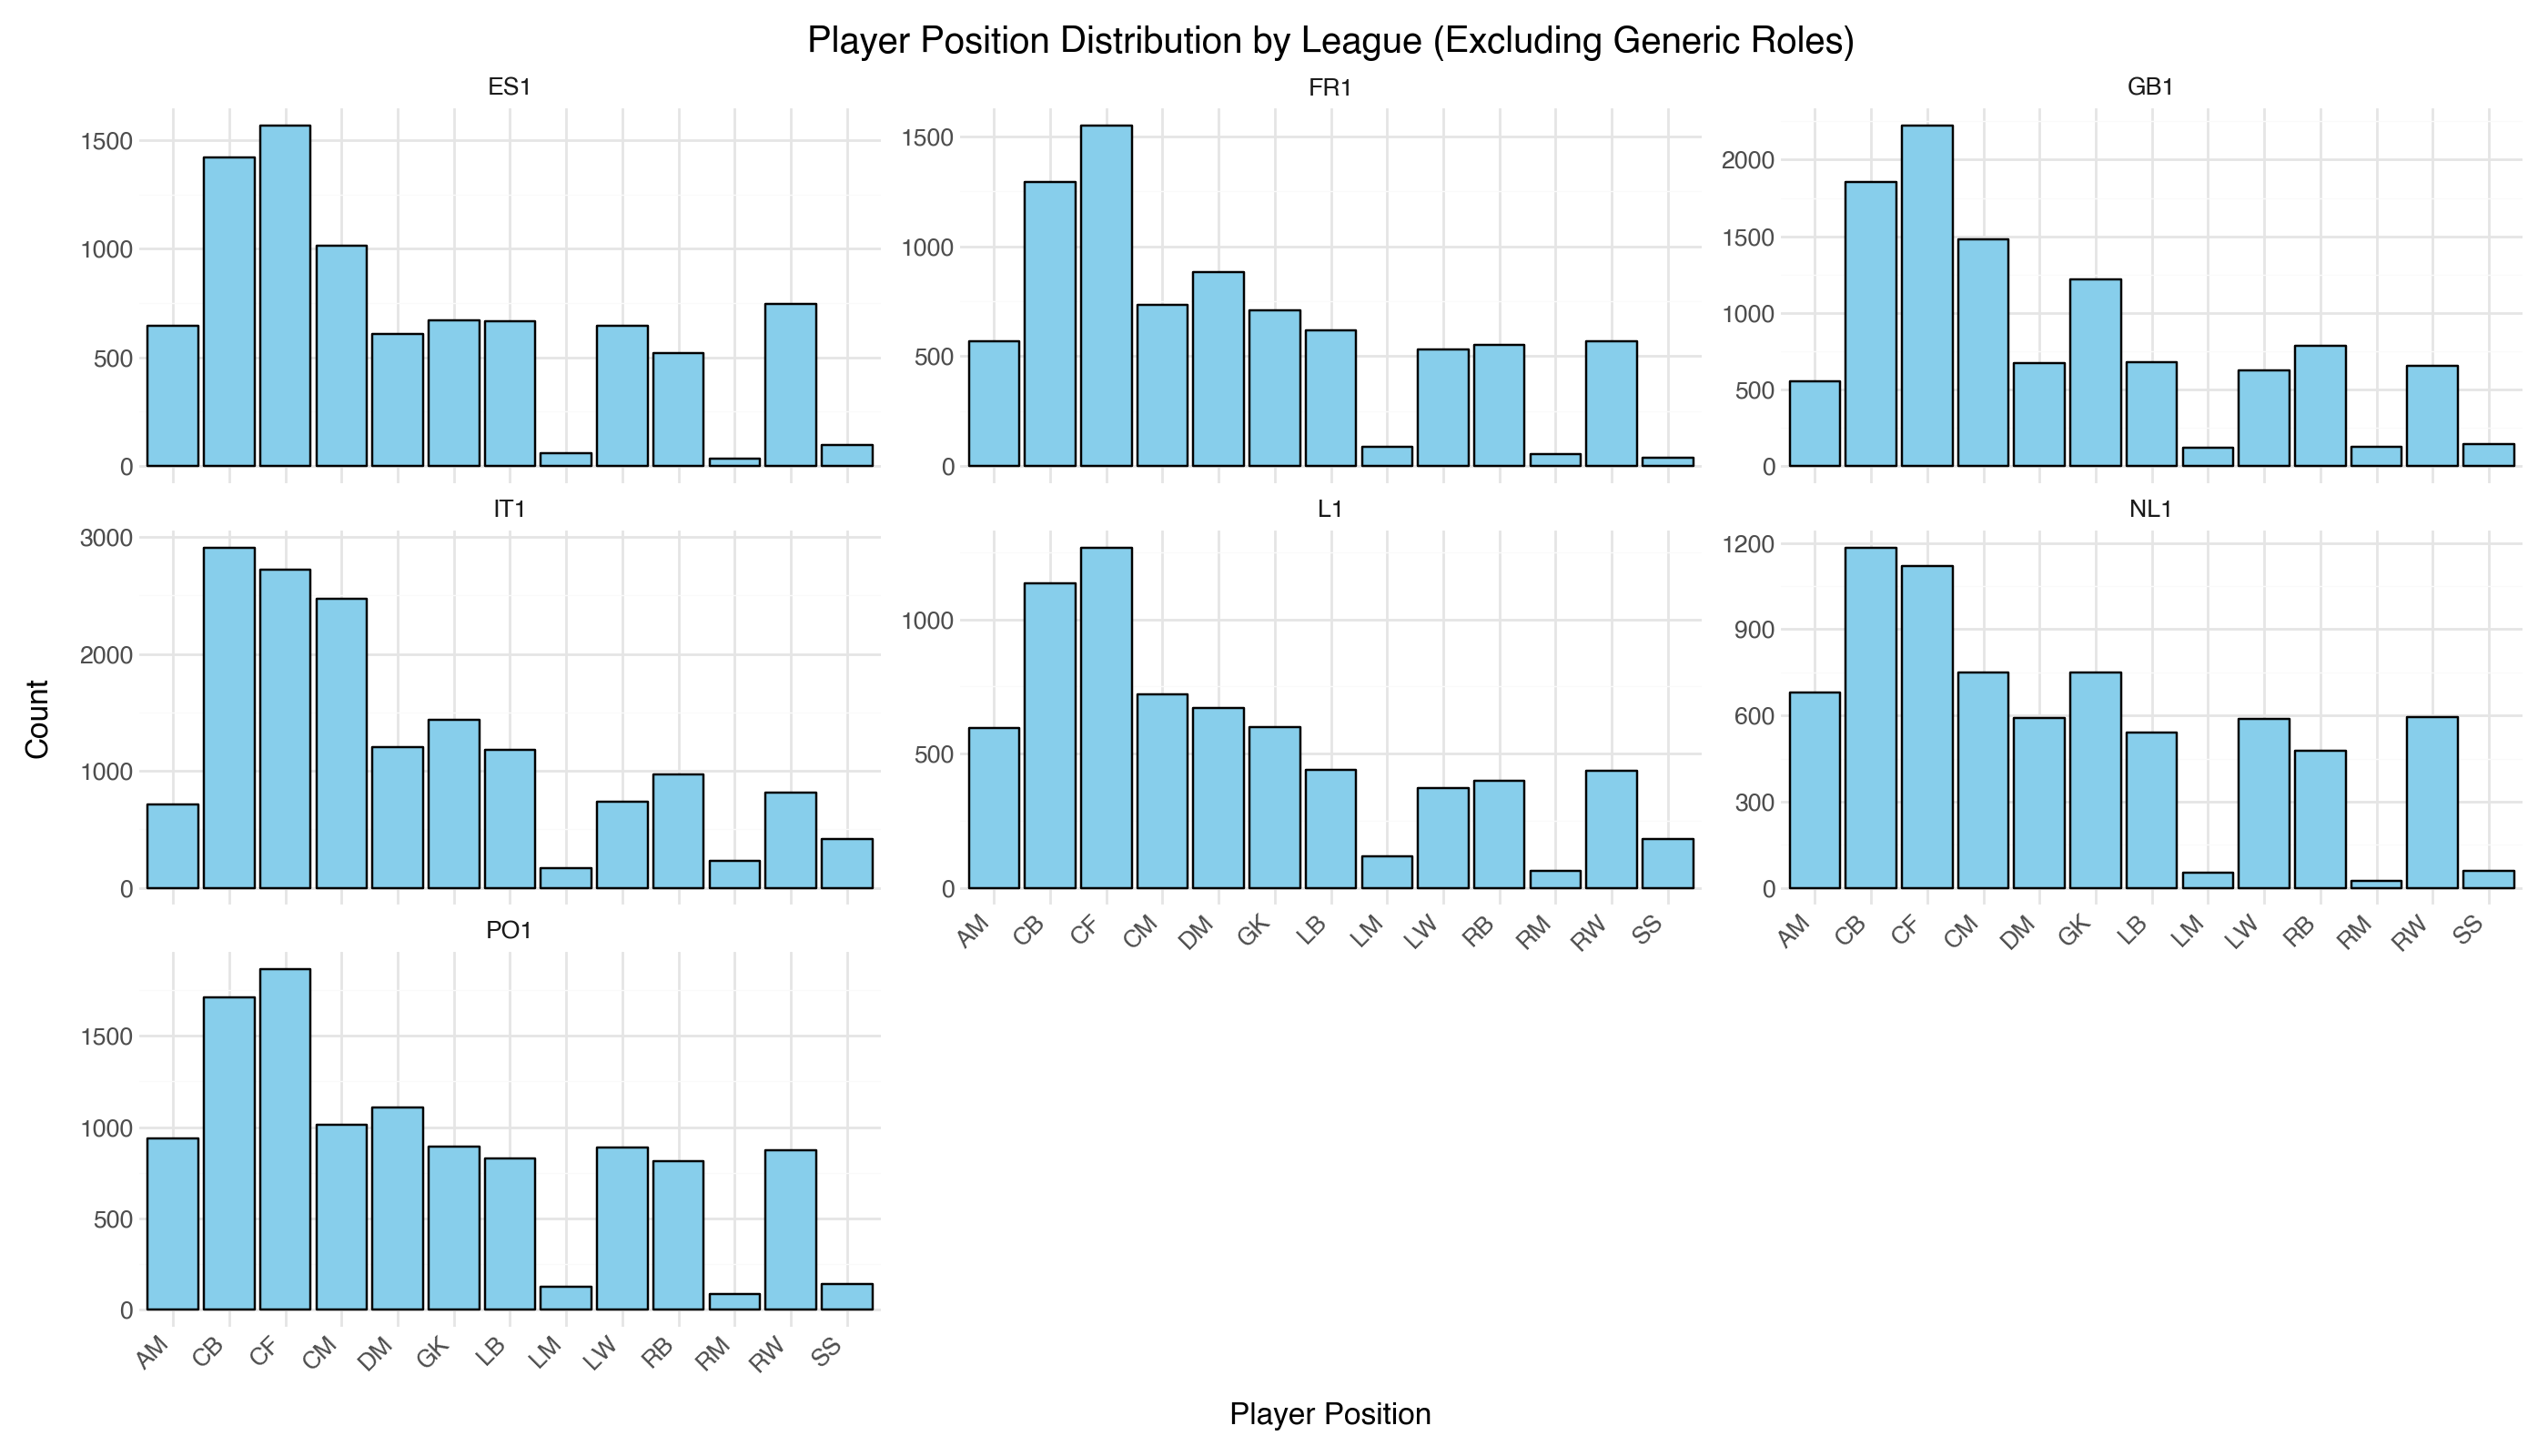

In [327]:
# Prepare data
freq_pos = (
    transfer_df.groupby(["league", "player_pos"], observed=True)
    .size()
    .reset_index(name="count")
    .sort_values("count")
)

# Plot
p = (
    ggplot(freq_pos, aes(x="player_pos", y="count")) +
    geom_bar(stat="identity", fill="#87CEEB", color="black") +
    facet_wrap("~league", scales="free_y", ncol=3) +
    theme_minimal(base_size=12) +
    theme(
        axis_text_x=element_text(rotation=45, ha='right'),
        figure_size=(14, 8),
    ) +
    labs(
        title="Player Position Distribution by League (Excluding Generic Roles)",
        x="Player Position",
        y="Count"
    )
)

p


2. We decided to explore the age distribution across the different leagues using a box plot for visualization which led us to formulating our second research question

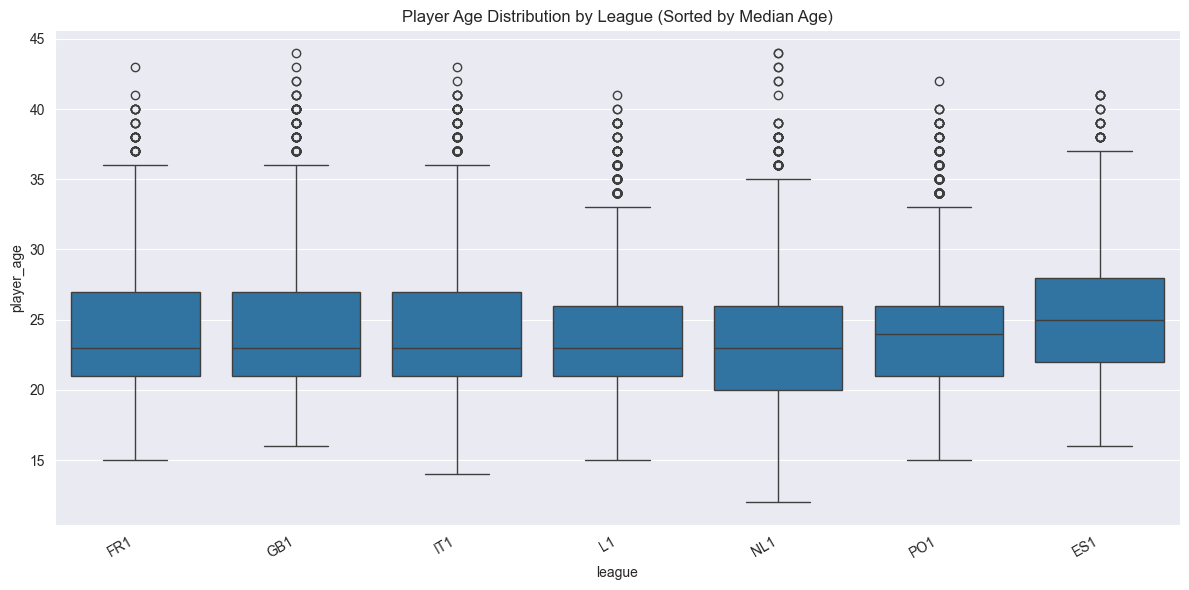

In [328]:
# Create new variable for median player age_distribution across leagues
order = (
    transfer_df.groupby('league', observed=True)['player_age']
    .median()
    .sort_values()
    .index
)

# Plot
plt.figure(figsize=(12,6))
sns.boxplot(
    data=transfer_df,
    x='league', y='player_age',
    order=order,
    showfliers=True
)
plt.title('Player Age Distribution by League (Sorted by Median Age)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

3. We decided to explore the number of transfers and average number of transfer spending across the different leagues which led us to our final research question

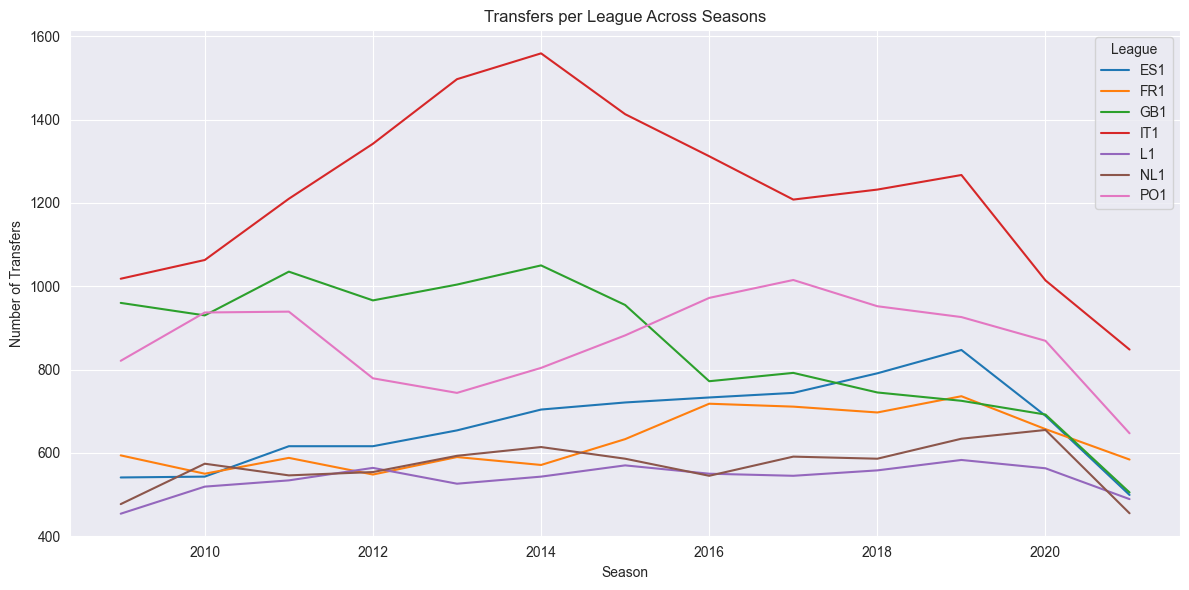

In [334]:
# Creating a pivot table
pivot = transfer_df.pivot_table(index = "season", columns = "league", values = "transfer_id", aggfunc = "count", observed= False)

# Plot
pivot.plot(figsize = (12,6))
plt.title("Transfers per League Across Seasons")
plt.xlabel("Season")
plt.ylabel("Number of Transfers")
plt.legend(title = "League")
plt.tight_layout()
plt.show()

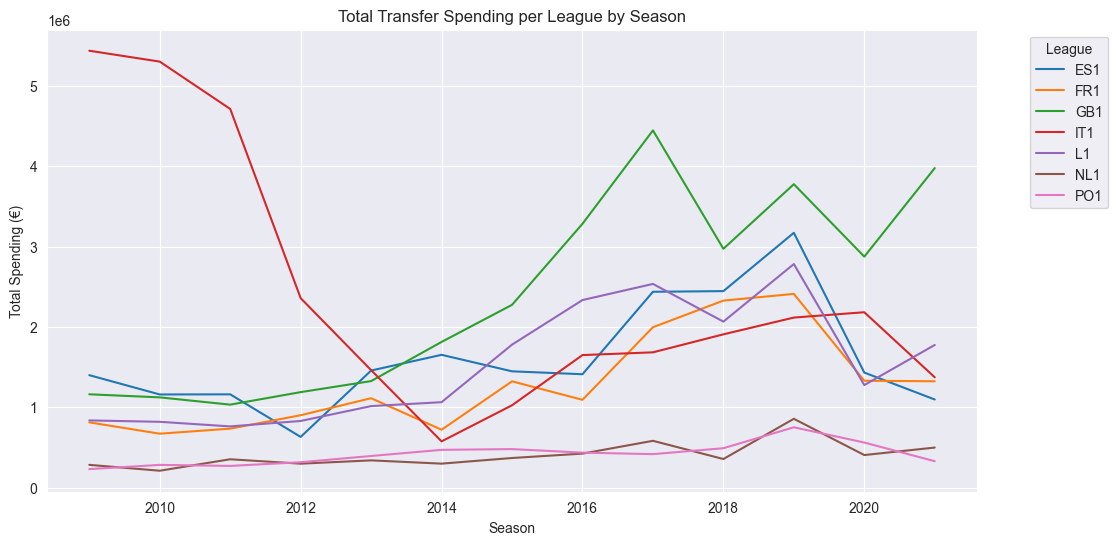

In [335]:
# Average Transfer Spending per League per Season
pivot_spending = df_transfer.pivot_table(
    index = "season",
    columns = "league",
    values = "transfer_fee_amnt",
    aggfunc = "mean",
    observed = False
)

# Plot
pivot_spending.plot(figsize = (12,6))
plt.title("Total Transfer Spending per League by Season")
plt.xlabel("Season")
plt.ylabel("Total Spending (€)")
plt.legend(title = "League", bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

### Research Question 1: Transfer patterns throughout the leagues (All leagues)
This research question examines player transfers across multiple leagues and seasons, focusing on player origins, transfer fees, and club spending behavior. It explores patterns in nationality and position dominance, tracks how much clubs invest in specific windows, and analyzes spending trends across different transfer windows and years. (Top 4 Position, CB, CF, CM, GK, amount of money spent in each League, differences?)

In [1]:
#THIS IS A COMMENT
transfer_df.info()

NameError: name 'transfer_df' is not defined

### Research Question 2:  How do Premier League clubs differ in their reliance on young player development compared to clubs that primarily acquire established players through transfers?
Using our scraped Premier League standings data across three seasons, This research question explores how youth-focused clubs which are clubs that focus on producing and promoting young talents, compared to clubs that rely more heavily on external signings in terms of performance. The analysis will explore where young players typically transfer to (e.g., domestic or international clubs) and how this reflects each club’s development strategy and success.

## Scraping Data

Since the dataset spans from 2008 to 2021, we first analyzed Premier League transfer spending trends to identify key phases that represent distinct club strategies. Based on this analysis, we selected three seasons — 2013–2014, 2016–2017, and 2019–2020 — for detailed comparison. The 2013–2014 season represents the early Financial Fair Play period, when clubs placed greater emphasis on youth development and internal promotion. The 2016–2017 season marks the peak of transfer expenditure, driven by the record-breaking broadcasting deal and a surge in acquisitions of established players. Finally, the 2019–2020 season captures a transitional period marked by reduced spending and a renewed reliance on younger players amid the financial impact of the COVID-19 pandemic. These three seasons will serve as a basis for comparing how Premier League clubs balance youth development and transfer spending, and how these strategies relate to league performance.


In [181]:
# Identify unique value for Premier League
transfer_df["league"].unique()

['GB1', 'ES1', 'IT1', 'L1', 'FR1', 'PO1', 'NL1']
Categories (7, object): ['ES1', 'FR1', 'GB1', 'IT1', 'L1', 'NL1', 'PO1']

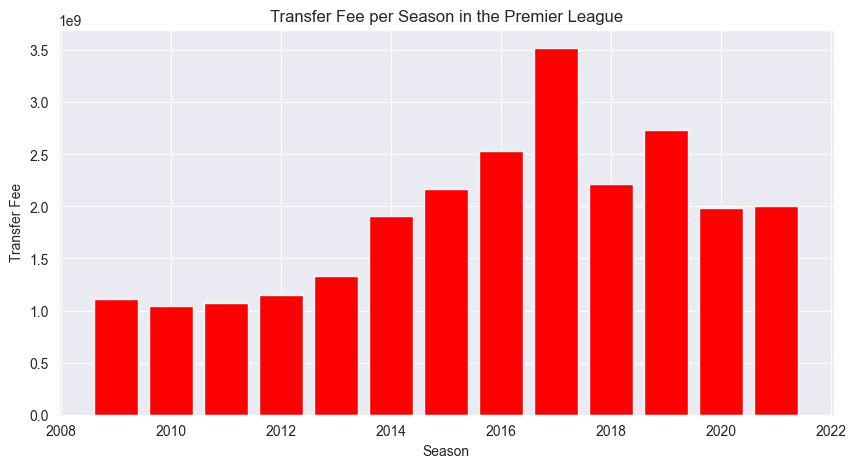

In [182]:
# Filter only Premier League
gb1 = transfer_df[transfer_df["league"] == "GB1"]

# Group by Leagues for transfers
season_spending = (
    gb1.groupby("season", observed = False)["transfer_fee_amnt"]
    .sum()
    .reset_index()
    .sort_values("season")
)

# Visualize Transfer fee by Seasons in the Premier League
plt.figure(figsize=(10, 5))
plt.bar(season_spending["season"], season_spending["transfer_fee_amnt"], color = "red")
plt.xlabel("Season")
plt.ylabel("Transfer Fee")
plt.title("Transfer Fee per Season in the Premier League")
plt.show()



In [183]:
# URL location for the data to be scrapped
url = "https://en.wikipedia.org/wiki/2013–14_Premier_League#League_table"

# Set up headers to mimic a regular web browser
myheaders = {"User-Agent" : "Mozilla/5.0 (X11; Linux x86_64; rv:130.0) Gecko/20100101 Firefox/130.0"}

# Send an HTTP GET request to download the webpage
page = requests.get(url, headers= myheaders)

# Parse the HTML content to create a structured BeautifulSoup object
soup = BeautifulSoup(page.text, "html")

In [184]:
print(soup)

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>2013–14 Premier League - Wikipedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled ve

In [185]:
table_2013_2014 = soup.find_all("table", class_ = "wikitable")[3]
print(table_2013_2014)

<table class="wikitable" style="text-align:center;">
<tbody><tr>
<th scope="col" width="28"><abbr title="Position">Pos</abbr>
</th>
<th scope="col" width="190">Team
</th>
<th scope="col" width="28"><abbr title="Played">Pld</abbr>
</th>
<th scope="col" width="28"><abbr title="Won">W</abbr>
</th>
<th scope="col" width="28"><abbr title="Drawn">D</abbr>
</th>
<th scope="col" width="28"><abbr title="Lost">L</abbr>
</th>
<th scope="col" width="28"><abbr title="Goals for">GF</abbr>
</th>
<th scope="col" width="28"><abbr title="Goals against">GA</abbr>
</th>
<th scope="col" width="28"><abbr title="Goal difference">GD</abbr>
</th>
<th scope="col" width="28"><abbr title="Points">Pts</abbr>
</th>
<th scope="col">Qualification or relegation
</th></tr>
<tr>
<td style="text-align: center;font-weight: normal;background-color:#BBF3BB;color:black;">1
</td>
<th scope="row" style="text-align: left; white-space:nowrap;font-weight: normal;background-color:#BBF3BB;color:black;"><a href="/wiki/Manchester_Cit

## Research Question 3: What is the impact of transfer activity on club performance across three recent seasons in the Premier League and La Liga?
This research question explores how the number and value of transfers (example total spending and number of transfers) influence key performance metrics such as final league standings, goals scored, and goals conceded. The comparison between the Premier league and La Liga aims to determine whether higher or more targeted spending correlates with improved performance outcomes.

### Resample to LaLiga and Premier League

Format your dataset suitable for your task (combine, merge, resample, …)

In [65]:
transfer_gb1 = transfer_df[transfer_df['league'] == 'GB1']
transfer_es1 = transfer_df[transfer_df['league'] == 'ES1']

In [ ]:
transfer_gb1.head(5)

## Scraping Data

– Find and interact with at least one dynamic element (search bar, buttons, list scroll, filter, ...) 
on the website.



– Use Selenium and BeautifulSoup 

#### Legal Aspect from the website

Bot/Scraping/Crawler Traffic on Sports-Reference.com Sites

Sports Reference is primarily dependent on ad revenue, so we must ensure that actual people using web browsers have the best possible experience when using this site. Unfortunately, non-human traffic, ie bots, crawlers, scrapers, can overwhelm our servers with the number of requests they send us in a short amount of time. Therefore we are implementing rate limiting on the site. We will attempt to keep this page up to date with our current settings.

Currently we will block users sending requests to:

FBref and Stathead sites more often than ten requests in a minute.
our other sites more often than twenty requests in a minute.
This is regardless of bot type and construction and pages accessed.
If you violate this rule your session will be in jail for up to a day.

### Simple Example

In [24]:
URL = "https://fbref.com/en/comps/9/2009-2010/2009-2010-Premier-League-Stats"
TABLE_ID = "results2009-201091_overall"

resp = requests.get(URL, headers={"User-Agent": "Mozilla/5.0"})
resp.raise_for_status()

soup = BeautifulSoup(resp.text, "lxml")
table = soup.find("table", id=TABLE_ID)

headers = [th.get_text(strip=True) for th in table.thead.find_all("th")]

rows = []
for tr in table.tbody.find_all("tr"):
    cells = [td.get_text(strip=True) for td in tr.find_all(["th", "td"])]
    if any(cells):
        rows.append(cells)

df_2009 = pd.DataFrame(rows, columns=headers)

HTTPError: 403 Client Error: Forbidden for url: https://fbref.com/en/comps/9/2009-2010/2009-2010-Premier-League-Stats

In [22]:
df_2009.head(5)

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Chelsea,38,27,5,6,103,32,+71,86,2.26,"41,423",Didier Drogba-29,Petr Čech,→ Champions League via league finish
1,2,Manchester Utd,38,27,4,7,86,28,+58,85,2.24,"74,864",Wayne Rooney-26,Edwin van der Sar,→ Champions League via league finish
2,3,Arsenal,38,23,6,9,83,41,+42,75,1.97,"63,256",Cesc Fàbregas-15,Manuel Almunia,→ Champions League via league finish
3,4,Tottenham,38,21,7,10,67,41,+26,70,1.84,"35,794",Jermain Defoe-18,Heurelho Gomes,→ Champions League via league finish
4,5,Manchester City,38,18,13,7,73,45,+28,67,1.76,"45,513",Carlos Tevez-23,Shay Given,→ Europa League via league finish


In [23]:
df_2009[['Top Team Scorer', 'Goals']] = df_2009['Top Team Scorer'].str.extract(r'(.+)-(\d+)', expand=True)

df_2009['Goals'] = df_2009['Goals'].astype(int)

cols = df_2009.columns.tolist()
insert_at = cols.index('Top Team Scorer') + 1
cols.insert(insert_at, cols.pop(cols.index('Goals')))
df_2009 = df_2009[cols]

In [31]:
df_2009.head(5)

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goals,Goalkeeper,Notes
0,1,Chelsea,38,27,5,6,103,32,+71,86,2.26,"41,423",Didier Drogba,29,Petr Čech,→ Champions League via league finish
1,2,Manchester Utd,38,27,4,7,86,28,+58,85,2.24,"74,864",Wayne Rooney,26,Edwin van der Sar,→ Champions League via league finish
2,3,Arsenal,38,23,6,9,83,41,+42,75,1.97,"63,256",Cesc Fàbregas,15,Manuel Almunia,→ Champions League via league finish
3,4,Tottenham,38,21,7,10,67,41,+26,70,1.84,"35,794",Jermain Defoe,18,Heurelho Gomes,→ Champions League via league finish
4,5,Manchester City,38,18,13,7,73,45,+28,67,1.76,"45,513",Carlos Tevez,23,Shay Given,→ Europa League via league finish


-----------------------------------

### Scraping 3 Seasons and their Final Standings

From the example above and with help from ChatGPT, we defined a function to extract three seasons from the Premier League’s final standings and scrape them into a single DataFrame.

In [39]:
def scrape_pl_results_overall(season: str) -> pd.DataFrame:
    url = f"https://fbref.com/en/comps/9/{season}/{season}-Premier-League-Stats"
    resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    resp.raise_for_status()

    soup = BeautifulSoup(resp.text, "lxml")
    table = soup.find("table", id=re.compile(r"^results.*_overall$"))
    if table is None:
        raise ValueError(f"Couldn't find results table for season {season} at {url}")

    headers = [th.get_text(strip=True) for th in table.thead.find_all("th")]

    rows = []
    for tr in table.tbody.find_all("tr"):
        cells = [td.get_text(strip=True) for td in tr.find_all(["th", "td"])]
        if any(cells):
            rows.append(cells)

    return pd.DataFrame(rows, columns=headers)

seasons = ["2013-2014", "2014-2015", "2015-2016"]

df_2013 = scrape_pl_results_overall("2013-2014")
df_2014 = scrape_pl_results_overall("2014-2015")
df_2015 = scrape_pl_results_overall("2015-2016")

In [41]:
df_2013[['Top Team Scorer', 'Goals']] = df_2013['Top Team Scorer'].str.extract(r'(.+)-(\d+)', expand=True)
df_2013['Goals'] = df_2013['Goals'].astype(int)

cols = df_2013.columns.tolist()
insert_at = cols.index('Top Team Scorer') + 1
cols.insert(insert_at, cols.pop(cols.index('Goals')))
df_2013 = df_2013[cols]


df_2014[['Top Team Scorer', 'Goals']] = df_2014['Top Team Scorer'].str.extract(r'(.+)-(\d+)', expand=True)
df_2014['Goals'] = df_2014['Goals'].astype(int)

cols = df_2014.columns.tolist()
insert_at = cols.index('Top Team Scorer') + 1
cols.insert(insert_at, cols.pop(cols.index('Goals')))
df_2014 = df_2014[cols]


df_2015[['Top Team Scorer', 'Goals']] = df_2015['Top Team Scorer'].str.extract(r'(.+)-(\d+)', expand=True)
df_2015['Goals'] = df_2015['Goals'].astype(int)

cols = df_2015.columns.tolist()
insert_at = cols.index('Top Team Scorer') + 1
cols.insert(insert_at, cols.pop(cols.index('Goals')))
df_2015 = df_2015[cols]

In [42]:
df_2013

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goals,Goalkeeper,Notes
0,1,Manchester City,38,27,5,6,102,37,+65,86,2.26,"47,080",Yaya Touré,20,Joe Hart,→ Champions League via league finish
1,2,Liverpool,38,26,6,6,101,50,+51,84,2.21,"44,671",Luis Suárez,31,Simon Mignolet,→ Champions League via league finish
2,3,Chelsea,38,25,7,6,71,27,+44,82,2.16,"41,482",Eden Hazard,14,Petr Čech,→ Champions League via league finish
3,4,Arsenal,38,24,7,7,68,41,+27,79,2.08,"60,013",Olivier Giroud,16,Wojciech Szczęsny,→ Champions League via league finish
4,5,Everton,38,21,9,8,61,39,+22,72,1.89,"37,732",Romelu Lukaku,15,Tim Howard,→ Europa League via league finish1
5,6,Tottenham,38,21,6,11,55,51,+4,69,1.82,"35,808",Emmanuel Adebayor,11,Hugo Lloris,→ Europa League via league finish
6,7,Manchester Utd,38,19,7,12,64,43,+21,64,1.68,"75,207",Wayne Rooney,17,David de Gea,
7,8,Southampton,38,15,11,12,54,46,+8,56,1.47,"30,212",Jay Rodriguez,15,Artur Boruc,
8,9,Stoke City,38,13,11,14,45,52,-7,50,1.32,"26,137","Charlie Adam,Peter Crouch",7,Asmir Begović,
9,10,Newcastle Utd,38,15,4,19,43,59,-16,49,1.29,"50,395",Loïc Rémy,14,Tim Krul,
